In [ ]:
import numpy as np
import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM, RNN
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, GRU
import time
from datetime import timezone
from datetime import datetime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install numpy==1.19.5

In [ ]:
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term



# Data Prep

In [ ]:
import pandas as pd

data = pd.read_pickle('/content/drive/MyDrive/Thesis/DATASETS/PeMS_dataset.pkl')

In [ ]:
data['Timestamp'] = data['Date'].dt.strftime('%Y-%m-%d').astype('str') +' '+ data['TOD'].astype('str')
data['Timestamp'] = data['Timestamp'].astype(np.datetime64)

In [ ]:
data = data.drop(['Date','TOD'],1).sort_values('Timestamp').reset_index(drop=True)
data.head()

,Travel Time,# Lane Pts,start,end,distance,Timestamp
0,3.38,37,SR 78,Centre City Pkwy,6.28,2020-01-10
1,42.95,441,Orange Co Line/I-605,I-5,77.90,2020-01-10
2,20.00,232,405-N/Wardlow Rd,405-N/National Blvd,35.89,2020-01-10
3,16.48,143,405-N/Sepulveda Blvd,405-N/Onion Ave,30.58,2020-01-10
4,21.83,250,405-N/Wardlow Rd,405-N/State Hwy 2,39.12,2020-01-10


In [ ]:
data

,Travel Time,# Lane Pts,start,end,distance,Timestamp
0,3.38,37,SR 78,Centre City Pkwy,6.28,2020-01-10 00:00:00
1,42.95,441,Orange Co Line/I-605,I-5,77.90,2020-01-10 00:00:00
2,20.00,232,405-N/Wardlow Rd,405-N/National Blvd,35.89,2020-01-10 00:00:00
3,16.48,143,405-N/Sepulveda Blvd,405-N/Onion Ave,30.58,2020-01-10 00:00:00
4,21.83,250,405-N/Wardlow Rd,405-N/State Hwy 2,39.12,2020-01-10 00:00:00
...,...,...,...,...,...,...
211387,16.48,144,405-N/Sepulveda Blvd,405-N/Onion Ave,30.58,2020-06-30 23:55:00
211388,19.82,233,405-N/Wardlow Rd,405-N/National Blvd,35.89,2020-06-30 23:55:00
211389,3.37,37,SR 78,Centre City Pkwy,6.28,2020-06-30 23:55:00
211390,42.82,443,Orange Co Line/I-605,I-5,77.90,2020-06-30 23:55:00


In [ ]:
# data['Timestamp'] = [str(date) for date in data['Timestamp']]

In [ ]:
data['Timestamp'][0]

Timestamp('2020-01-10 00:00:00')

In [ ]:
data['dept_hour'] = data['Timestamp'].dt.hour
data['dept_minute'] = data['Timestamp'].dt.minute
data['dept_dayofweek'] = data['Timestamp'].dt.dayofweek
data['dept_monthofyear'] = data['Timestamp'].dt.month

In [ ]:
# from sklearn.model_selection import train_test_split

# X = data.drop(['Travel Time'],1)
# y = data['Travel Time']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = X['dept_monthofyear'], random_state=1)

In [ ]:
# Encoding make column using LabelEncoder
from sklearn.preprocessing import LabelEncoder

encoded_data = pd.get_dummies(data, columns=['start','end'], drop_first=True)

labelencoder = LabelEncoder()

encoded_data['LanePts'] = labelencoder.fit_transform(encoded_data['# Lane Pts'])

processed_data = encoded_data.drop(['# Lane Pts','Timestamp'],1)

In [ ]:
data, target = processed_data.drop(['Travel Time'],1), processed_data['Travel Time']

In [ ]:
# train_x, train_y = data[0:167904], target[0:167904]
# test_x, test_y = data[167904:], target[167904:]

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.20, random_state=1)

In [ ]:
train_test_data = [train_x, test_x, train_y, test_y]
name = ['train_x', 'test_x', 'train_y', 'test_y']

import pickle

for d,n in zip(train_test_data,name):
  with open('/content/drive/MyDrive/Thesis/DATASETS/PeMS_data/'+ n +'.pkl','wb') as f:
    pickle.dump(d, f)

In [12]:
# Using SciKit Learn

from sklearn.preprocessing import StandardScaler,MinMaxScaler

def data_preprocesing(data,target,data_len):

  scaler = MinMaxScaler()

  data.iloc[:,0:] = scaler.fit_transform(data.iloc[:,0:].to_numpy())

  X = data
  y = target

  data_x = np.array(X, dtype=float)
  data_x = data_x.reshape((data_len,17,1))

  target = np.array(y, dtype=float)
  # target = target.reshape(169113,1,1)

  return data_x, target

In [23]:
test_x.shape

(42279, 17)

In [13]:
with open('/content/drive/MyDrive/Thesis/DATASETS/PeMS_data/train_x.pkl','rb') as f:
  train_x = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/DATASETS/PeMS_data/train_y.pkl','rb') as f:
  train_y = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/DATASETS/PeMS_data/test_x.pkl','rb') as f:
  test_x = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/DATASETS/PeMS_data/test_y.pkl','rb') as f:
  test_y = pickle.load(f)

In [16]:
train_x, train_y = data_preprocesing(train_x, train_y, 169113)

In [24]:
test_x, test_y = data_preprocesing(test_x, test_y, 42279)

In [ ]:
# train_data = processed_data[processed_data.dept_monthofyear < 6]
# test_data = processed_data[processed_data.dept_monthofyear == 6]

# Model Training

In [17]:
# callback = callbacks.EarlyStopping(monitor='val_loss', patience = 3)

model = Sequential()  
model.add(LSTM(64, input_shape=(17, 1),return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64))
# model.add(Dense(64))
model.add(Dense(1, activation= "linear"))
model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['accuracy','mse'])
# model.fit(data, target, epochs=1000, batch_size=1, verbose=2,validation_data=(x_test, y_test))

In [ ]:
# model = Sequential()  
# model.add(LSTM((64), batch_input_shape=(None,17,1),return_sequences=False))
# # model.add(Dropout(0.2))
# model.add(Dense(64))
# # model.add(Dropout(0.2))
# model.add(Dense(1, activation= "linear"))
# model.compile(loss='mean_absolute_error',optimizer='adam',metrics=['accuracy','mse'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 17, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 54,145
Trainable params: 54,145
Non-trainable params: 0
_________________________________________________________________


In [25]:
tmp = time.time()
# epochs=50
# learning_rate = 0.1
# decay_rate = learning_rate / epochs
# momentum = 0.8

history = model.fit(train_x,train_y,epochs=50,validation_data=(test_x,test_y))
gpu_time = time.time() - tmp
print("GPU Training Time: %s seconds" % (str(gpu_time)))

Train on 169113 samples, validate on 42279 samples
Epoch 1/50
169088/169113 [============================>.] - ETA: 0s - loss: 5.1210 - acc: 0.0000e+00 - mean_squared_error: 129.6385

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


169113/169113 [==============================] - 105s 623us/sample - loss: 5.1209 - acc: 0.0000e+00 - mean_squared_error: 129.6260 - val_loss: 2.4984 - val_acc: 0.0000e+00 - val_mean_squared_error: 24.3004
Epoch 2/50
169113/169113 [==============================] - 99s 583us/sample - loss: 1.7887 - acc: 0.0000e+00 - mean_squared_error: 10.8920 - val_loss: 1.6810 - val_acc: 0.0000e+00 - val_mean_squared_error: 6.3408
Epoch 3/50
169113/169113 [==============================] - 97s 572us/sample - loss: 1.1905 - acc: 0.0000e+00 - mean_squared_error: 4.1950 - val_loss: 1.0342 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.7056
Epoch 4/50
169113/169113 [==============================] - 98s 580us/sample - loss: 1.1021 - acc: 0.0000e+00 - mean_squared_error: 3.7799 - val_loss: 1.1579 - val_acc: 0.0000e+00 - val_mean_squared_error: 4.0601
Epoch 5/50
169113/169113 [==============================] - 97s 574us/sample - loss: 1.0825 - acc: 0.0000e+00 - mean_squared_error: 3.7027 - val_loss: 1.1

# Save Model

In [26]:
# model.save('LSTM_2_layer')

# !mkdir -p saved_model
model.save('/content/drive/MyDrive/Thesis/DATASETS/LSTM/LSTM_2_layer_PeMS.h5')

# tf.keras.models.save_model

# Load Saved Model

In [27]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Thesis/DATASETS/LSTM/LSTM_2_layer_PeMS.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Train Accuracy

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


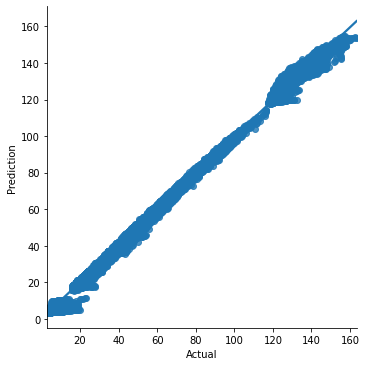

In [28]:
prediction = new_model.predict(train_x)
prediction = [i[0] for i in prediction]

pre_ac = pd.DataFrame()

pre_ac['Actual'] = train_y
pre_ac['Prediction'] = prediction

import seaborn as sns

sns.lmplot(x="Actual", y="Prediction", data=pre_ac);

In [31]:
mae = mean_absolute_error(train_y, prediction)
errors = abs(prediction - train_y)
# mape = 100 * np.mean(np.abs(errors / test_y))
# accuracy = 100 - mape
MSE = np.square(np.subtract(train_y,prediction)).mean() 
RMSE = math.sqrt(MSE)
R2 = r2_score(train_y,prediction)

print('Model Performance')
print('MAE: {:0.4f} minutes.'.format(np.mean(errors)))
print('RMSE: {:0.2f}.'.format(RMSE))
print('R2: {:0.2f}.'.format(R2))
# print('Accuracy = {:0.2f}%.'.format(accuracy))

Model Performance
MAE: 0.4968 minutes.
RMSE: 0.85.
R2: 1.00.


# Test Accuracy

In [32]:
prediction = new_model.predict(test_x)

In [33]:
prediction = [i[0] for i in prediction]

In [34]:
pre_ac = pd.DataFrame()

pre_ac['Actual'] = test_y
pre_ac['Prediction'] = prediction
pre_ac['travels'] = [l for l in range(0,len(prediction))]

In [ ]:
# pre_ac

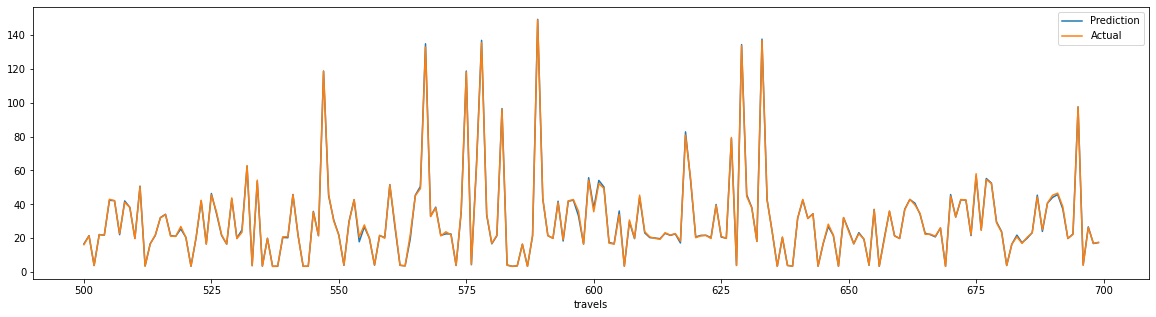

In [36]:
import matplotlib.pyplot as plt

##### plot according to time of day

pre_ac[500:700].plot(x= "travels" , y=['Prediction', 'Actual'])
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

In [ ]:
# pre_ac.plot()

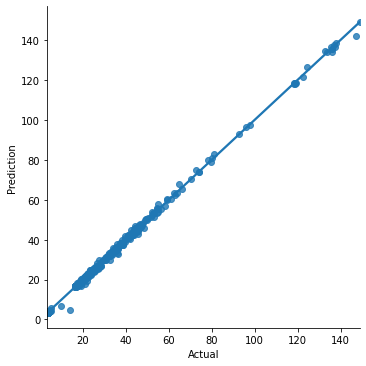

In [37]:
import seaborn as sns

sns.lmplot(x="Actual", y="Prediction", data=pre_ac[500:1000]);

In [30]:
from sklearn.metrics import mean_absolute_error, r2_score
import math

# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)
#     mae = mean_absolute_error(test_labels, predictions)
#     errors = abs(predictions - test_labels)
#     mape = 100 * np.mean(np.abs(errors / test_labels))
#     accuracy = 100 - mape
#     MSE = np.square(np.subtract(test_labels,predictions)).mean() 
#     RMSE = math.sqrt(MSE)
#     R2 = r2_score(test_labels,predictions)
#     print('Model Performance')
#     print('MAE: {:0.4f} minutes.'.format(np.mean(errors)))
#     print('RMSE: {:0.2f}.'.format(RMSE))
#     print('R2: {:0.2f}.'.format(R2))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
    
#     return accuracy

In [38]:
mae = mean_absolute_error(test_y, prediction)
errors = abs(prediction - test_y)
mape = 100 * np.mean(np.abs(errors / test_y))
accuracy = 100 - mape
MSE = np.square(np.subtract(test_y,prediction)).mean() 
RMSE = math.sqrt(MSE)
R2 = r2_score(test_y,prediction)

In [39]:
print('Model Performance')
print('MAE: {:0.4f} minutes.'.format(np.mean(errors)))
print('RMSE: {:0.2f}.'.format(RMSE))
print('R2: {:0.2f}.'.format(R2))
print('MAPE = {:0.2f}%.'.format(mape))
print('Accuracy = {:0.2f}%.'.format(accuracy))

Model Performance
MAE: 0.5087 minutes.
RMSE: 0.87.
R2: 1.00.
MAPE = 1.96%.
Accuracy = 98.04%.


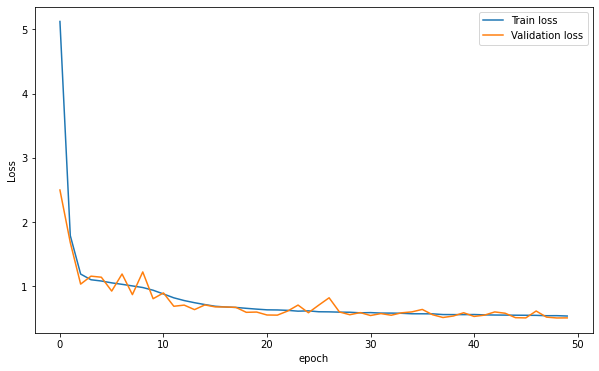

In [40]:
def plot_loss(history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    
plot_loss(history)

In [ ]:
# SHAP

In [41]:
!pip install shap

     |████████████████████████████████| 358kB 8.3MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491619 sha256=c457aeb542ba3e71b7c4e50da0d873a57f624389b0c142195a6477e05bed1a51
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [42]:
import shap

explainer = shap.DeepExplainer(new_model,train_x[0:10000])
shap_values = explainer.shap_values(test_x[0:10])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


In [43]:
a = np.array([x[0] for x in shap_values[0][0]])

In [44]:
shap_value = np.array([[x[0] for x in shap_values[0][y]] for y in range(0,len(shap_values[0]))])

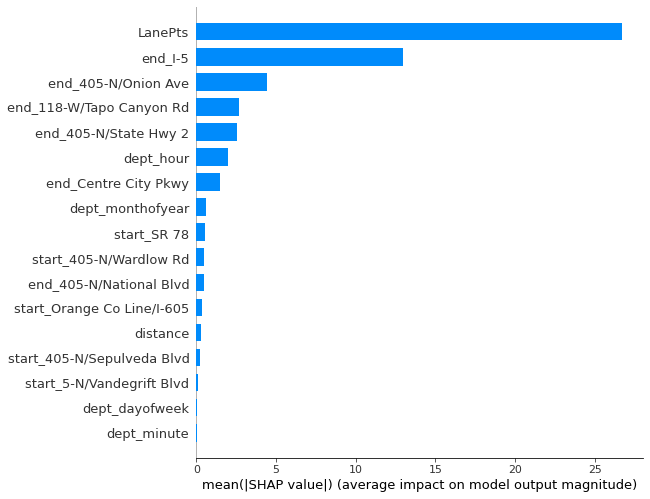

In [46]:
shap.summary_plot(shap_value, train_x, feature_names = data.columns, plot_type="bar")

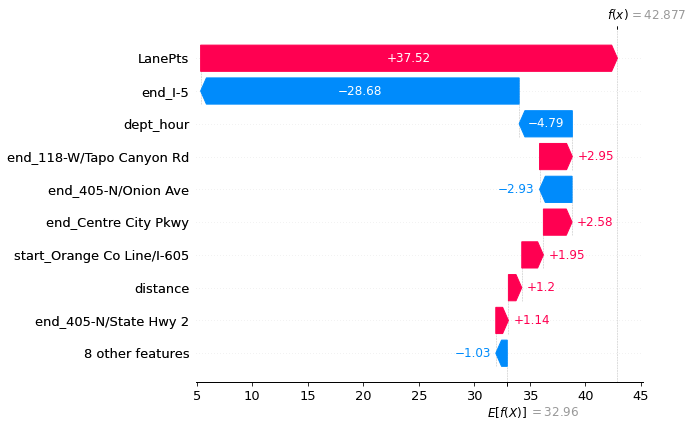

In [ ]:
'''The explanation below shows features each contributing to push the model output from the base value 
(the average model output over the training dataset we passed) to the model output. Features pushing the 
prediction higher are shown in red, those pushing the prediction lower are in blue.'''
# load JS visualization code to notebook
shap.initjs()

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], a, feature_names = X.columns, show = True)

In [ ]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.force_plot(explainer.expected_value, a, feature_names = X.columns, show = True)